In [42]:
import numpy as np
import q_learning as ql
import utils
import model

In [62]:
def phi_e(x:np.ndarray, std_e : float = 1.0) -> np.ndarray:
    return model.LQR_policy(x) + std_e * np.random.randn(1)

def psi_Q(x : np.ndarray, u : np.ndarray) -> np.ndarray:

    if not np.isscalar(u):
        u = u[0]
        
    x1 = x[0]
    x4 = x[3]
    x5 = x[4]
    psi = [x1**2, x4**2, x5**2, u**2, x1*u, x4*u, x5*u,\
             x1*x4, x1*x5, x4*x5]

    return np.array(psi)

def policy_Q(x : np.ndarray, theta : np.ndarray) -> np.ndarray:
    sum = theta[4]*x[0] + theta[5]*x[3] + theta[6]*x[4]
    return - sum / (2*theta[3])

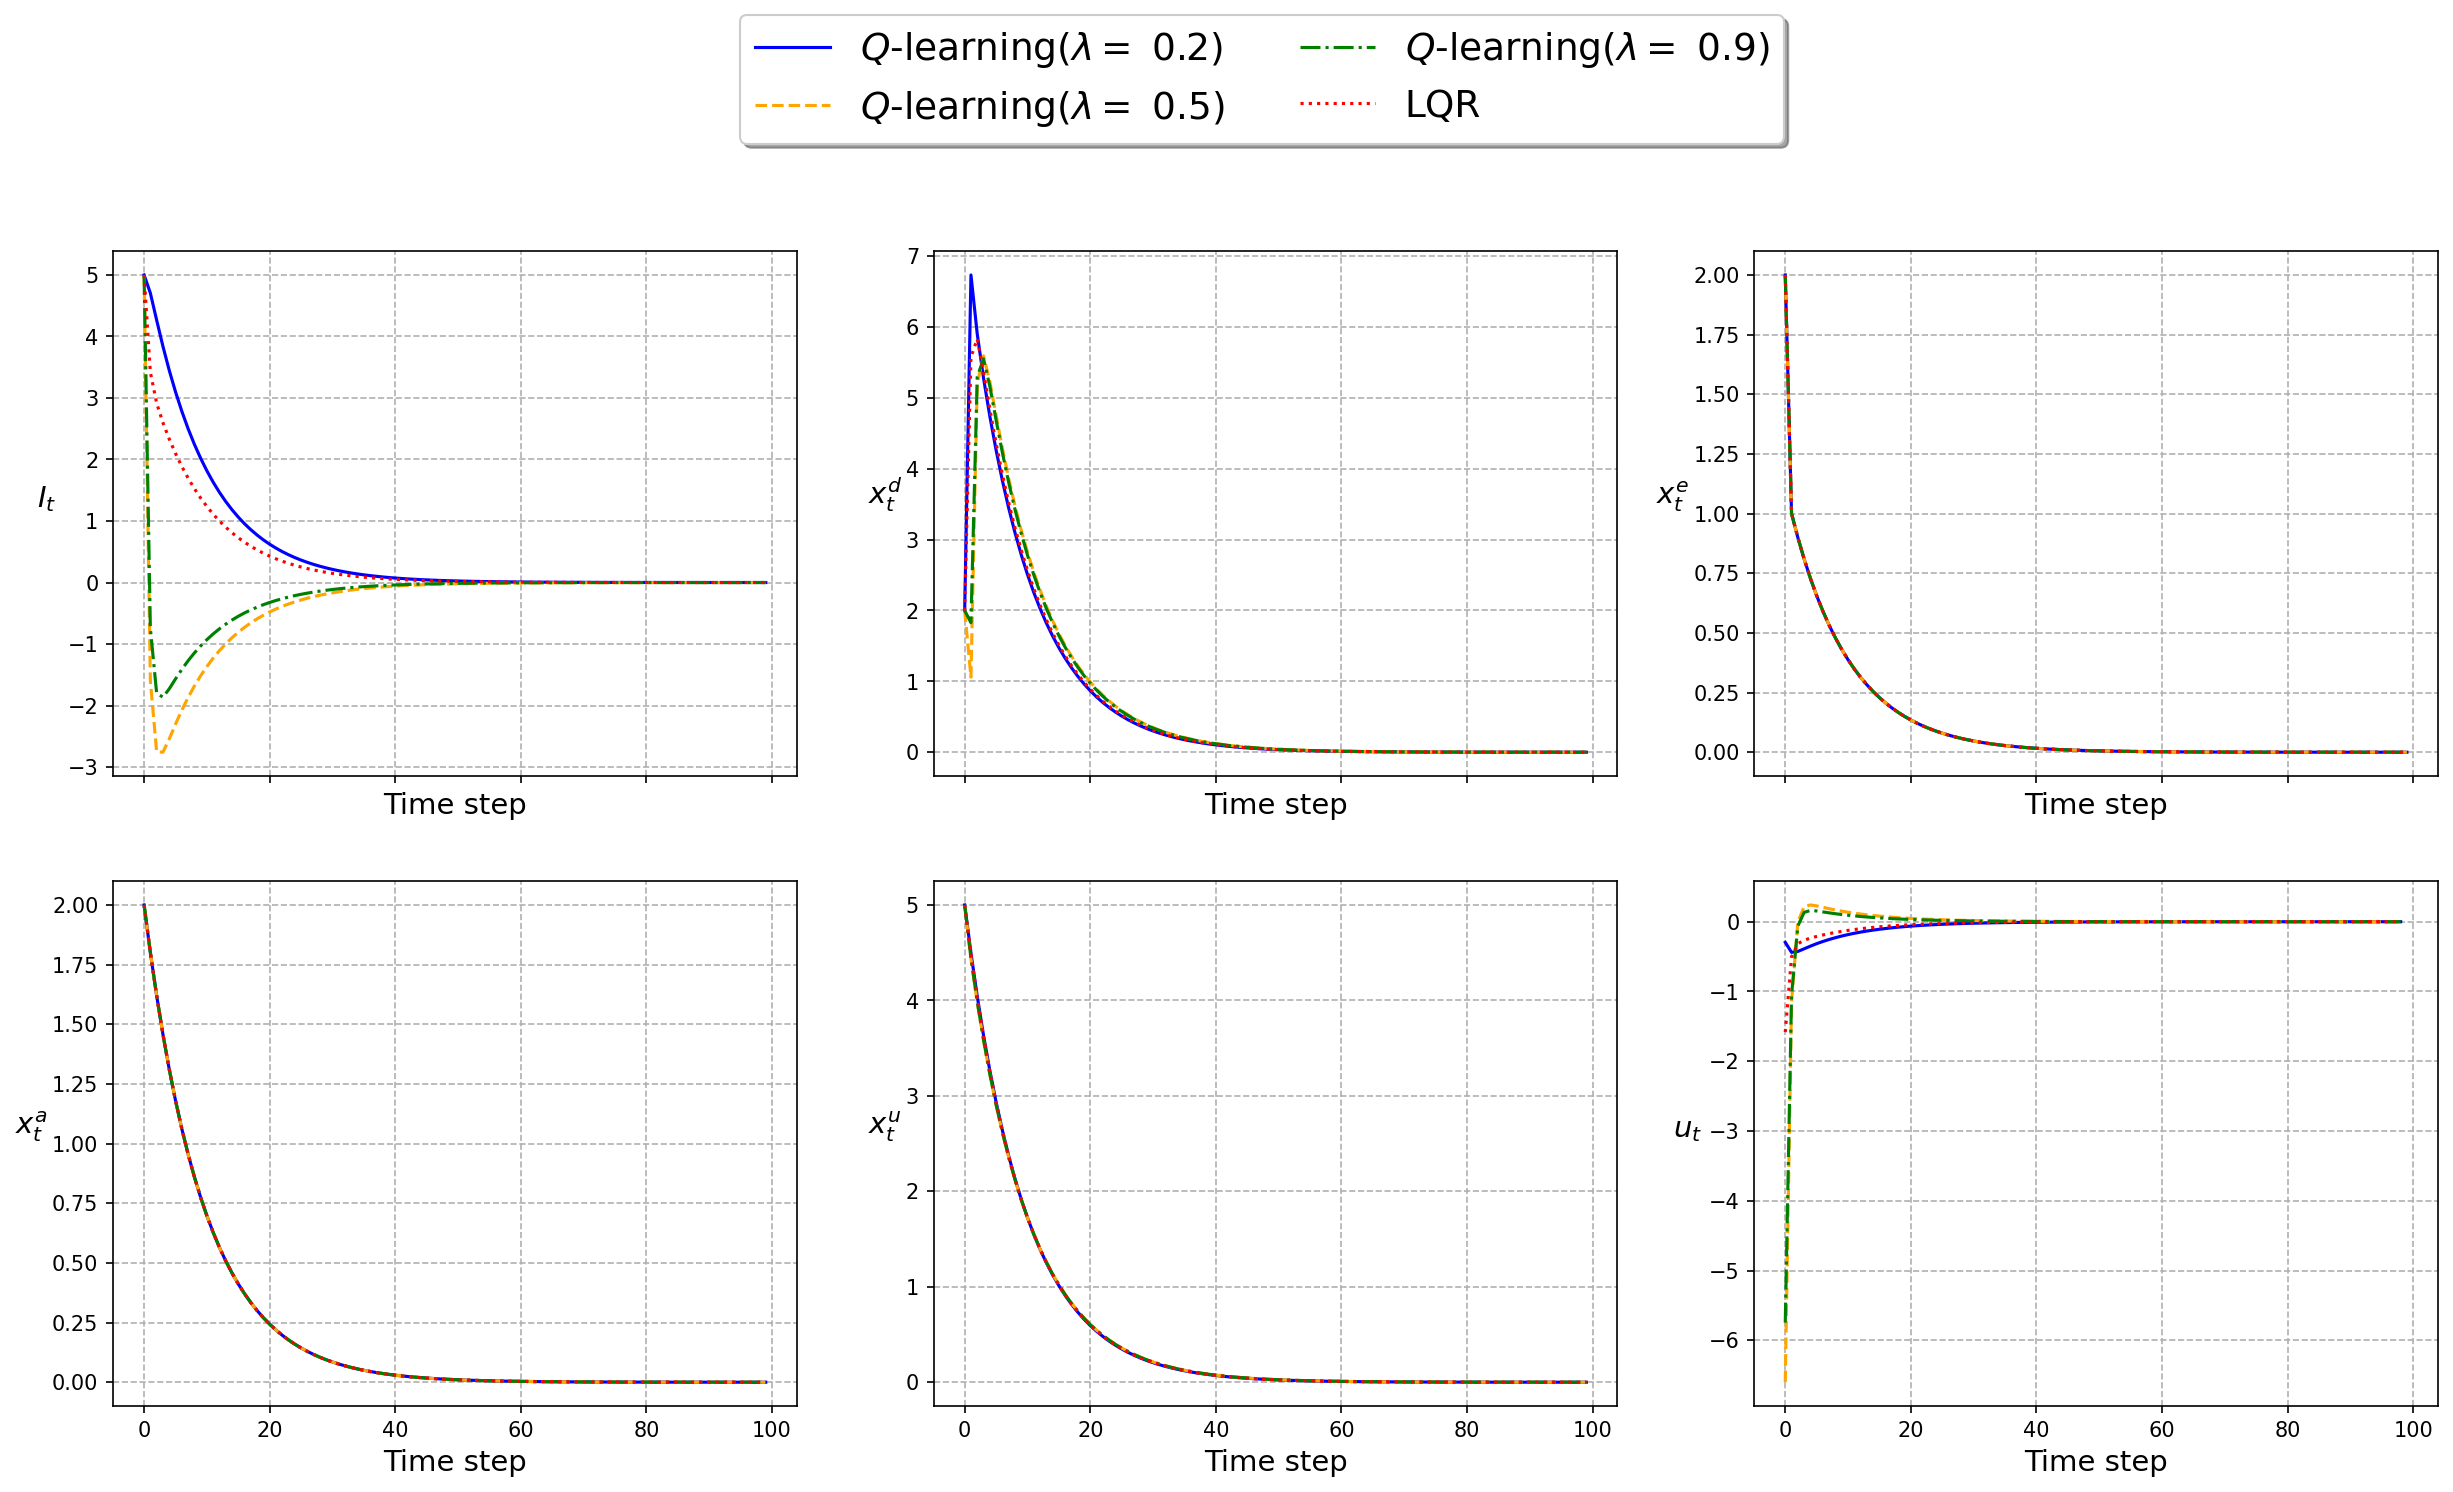

In [90]:
# Parameters

x0_train = np.array([2, 2, 2, 2, 10])
x0_test = np.array([5, 2, 2, 2, 5])
nstep =  5000
theta0 = np.ones(10)
zeta0 = np.random.rand(10)
alpha = lambda k : 1e-3 / (k+1)
psi = psi_Q
data_train = model.simulate_linear_model(x0_train, phi_e, nstep)

# Q-learning
data_plot = {}
for lam in [0.2, 0.5, 0.9]:
    theta = ql.q_learning(lam, theta0, zeta0, alpha, psi, data_train)
    data_plot[ rf"$Q$-learning($\lambda = $ {lam})"] = model.simulate_linear_model(x0_test, lambda x : policy_Q(x, theta), 100)



# Plotting

data_plot["LQR"] = model.simulate_linear_model(x0_test, model.LQR_policy, 100)

utils.show_trajectories(data_plot, save="trajectories_Q_learning.pdf")

In [ ]:
def compute_TD(data : np.ndarray, Q : callable, phi : callable) -> np.ndarray:
    x, u = data
    TD = np.empty(x.shape[1] - 1)

    for k in range(x.shape[1]-1):

        x_k = x[:, k]
        u_k = u[:, k]
        x_k_plus = x[:, k+1]

        TD[k] = model.cost(x_k, u_k) + Q(x_k_plus, phi(x_k_plus)) - Q(x_k, u_k)

    return TD

In [98]:
# Parameters

x0_train = np.array([2, 2, 2, 2, 10])
x0_test = np.array([5, 2, 2, 2, 5])
nstep =  5000
theta0 = np.ones(10)
zeta0 = np.random.rand(10)
alpha = lambda k, c : c / (k+1)
psi = psi_Q
data_train = model.simulate_linear_model(x0_train, phi_e, nstep)

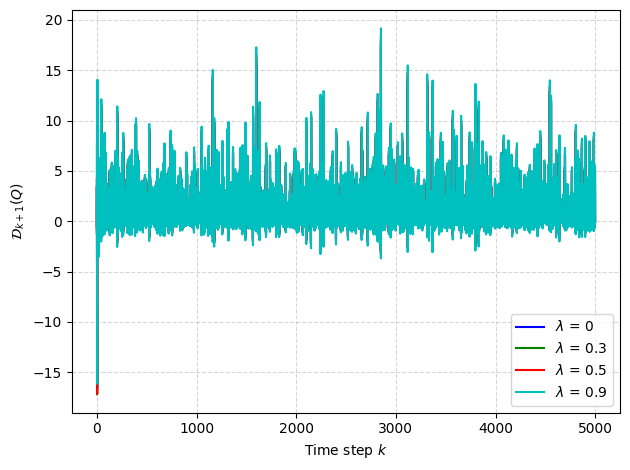

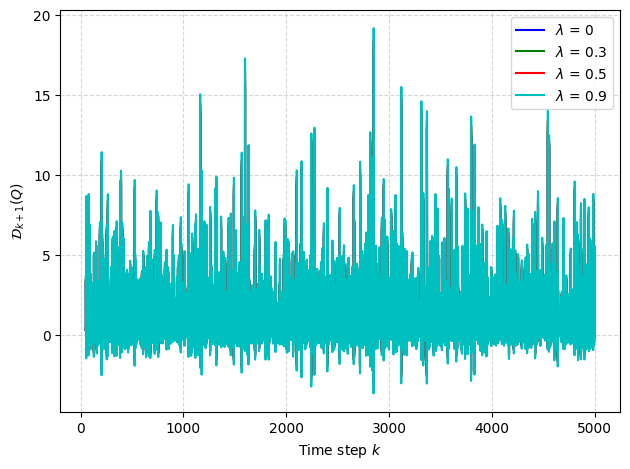

In [109]:
import matplotlib.pyplot as plt
lam = [0, 0.3, 0.5, .9]
colors = ['b', 'g', 'r', 'c', 'm']
TD_all = []
factor = 1e-3

for i in range(len(lam)):
    theta_qlearn = ql.q_learning(lam[i], theta0, zeta0, lambda k: alpha(k,factor), psi, data_train)

    def policy_qlearn(x: np.ndarray) -> np.ndarray:
        return policy_Q(x, theta_qlearn)

    TD = compute_TD(data_train, lambda x, u : np.dot(psi_Q(x, u), theta_qlearn), policy_qlearn)
    TD_all.append(TD)

for i in range(len(lam)):
    plt.plot(TD_all[i], label='$\lambda$ = ' + str(lam[i]), color = colors[i])

plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig('figures/temp_diff_lambdaQlearn.pdf',dpi=300)
plt.show()

time = np.arange(50, nstep-1)
for i in range(len(lam)):
    plt.plot(time, TD_all[i][50:], label='$\lambda$ = ' + str(lam[i]), color = colors[i])


plt.xlabel('Time step $k$')
plt.ylabel('$\\mathcal{D}_{k+1}(Q)$')
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# plt.savefig('temp_diff_lambdaQlearn_zoom.pdf',dpi=300)
plt.show()